In [1]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Dataset
import os
from PIL import Image
import pandas as pd

from custom_dataset import MMHS_150KDataset
from vilbert_adapt import VilBertForHatefulContentDetection

c:\Users\adrie\.conda\envs\DL_mp\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# step 1: preprocessing and data loading

In [2]:
# Define transformations for image preprocessing
data_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalizing using ImageNet statistics
])

# Define dataset
dataset_path = ''
image_path = os.path.join(dataset_path, 'dataset/img_resized')
text_path = os.path.join(dataset_path, 'dataset/img_txt')
GT_path = os.path.join(dataset_path, 'dataset/MMHS150K_GT.csv')
dataset = MMHS_150KDataset(GT_path, image_path, transform=data_transforms)

# Split dataset into training, validation, and test sets 
train_size = int(0.8 * len(dataset))
val_size = (len(dataset) - train_size) // 2
test_size = len(dataset) - train_size - val_size
train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, val_size, test_size])

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

c:\Users\adrie\.conda\envs\DL_mp\Lib\site-packages\huggingface_hub\file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


visual inspection of step 1

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


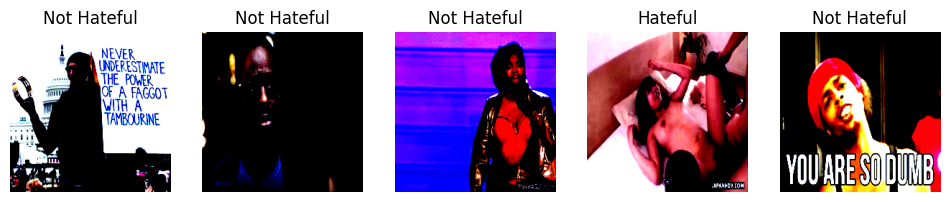

In [3]:
import matplotlib.pyplot as plt

# Function to display images from the dataset
def show_samples(dataset, num_samples=5):
    plt.figure(figsize=(12, 8))
    for i in range(num_samples):
        image, _, _, label = dataset[i]
        image = image.permute(1, 2, 0)  # Reorder dimensions for visualization (C, H, W) to (H, W, C)
        image = image.numpy()  # Convert torch tensor to numpy array
        label = "Hateful" if label == 1 else "Not Hateful"
        plt.subplot(1, num_samples, i+1)
        plt.imshow(image)
        plt.title(label)
        plt.axis('off')
    plt.show()

# Show samples from training dataset
show_samples(train_dataset, num_samples=5)

# step 2: Model building

In [4]:
model = VilBertForHatefulContentDetection(2)

c:\Users\adrie\.conda\envs\DL_mp\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\adrie\.conda\envs\DL_mp\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet101_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet101_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
c:\Users\adrie\.conda\envs\DL_mp\Lib\site-packages\huggingface_hub\file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [5]:
# Instantiate the model
model = VilBertForHatefulContentDetection(num_classes=2)

# Move the model to the appropriate device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Generate dummy input tensors
dummy_images = torch.randn(1, 3, 224, 224).to(device)  # Assuming batch size of 1 and image size of 224x224
dummy_input_ids = torch.randint(0, 1000, (1, 128)).to(device)  # Assuming maximum sequence length of 128 and vocabulary size of 1000
dummy_attention_mask = torch.ones_like(dummy_input_ids).to(device)  # Assuming all tokens are attended to

# Pass dummy inputs through the model
output = model(dummy_images, dummy_input_ids, dummy_attention_mask)

# Print output shape
print(output.shape)


torch.Size([1, 2])


# step 3: Model training

In [6]:
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from tqdm import tqdm

def train_model(model, train_loader, val_loader, num_epochs=5, learning_rate=0.001):
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    model.to(device)
    
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    
    for epoch in range(num_epochs):
        # Training phase
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0
        for images, input_ids, attention_mask, labels in tqdm(train_loader, desc=f'Epoch {epoch + 1}/{num_epochs} - Training'):
            images, input_ids, attention_mask, labels = images.to(device), input_ids.to(device), attention_mask.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images, input_ids, attention_mask)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            running_loss += loss.item() * images.size(0)
        train_loss = running_loss / len(train_loader.dataset)
        train_accuracy = correct / total
        
        # Validation phase
        model.eval()
        val_loss = 0.0
        correct = 0
        total = 0
        with torch.no_grad():
            for images, labels in tqdm(val_loader, desc=f'Epoch {epoch + 1}/{num_epochs} - Validation'):
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item() * images.size(0)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
        val_loss = val_loss / len(val_loader.dataset)
        val_accuracy = correct / total
        
        print(f'Epoch {epoch + 1}/{num_epochs}, Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.4f}')

# Example usage
train_model(model, train_loader, val_loader, num_epochs=5, learning_rate=0.0001)


Epoch 1/5 - Training:   0%|          | 0/1482 [00:00<?, ?it/s]

Epoch 1/5 - Training:   0%|          | 0/1482 [00:01<?, ?it/s]


OutOfMemoryError: CUDA out of memory. Tried to allocate 26.00 MiB. GPU 